In [1]:
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms as T
import numpy as np
from albumentations import Compose, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, GaussNoise, Rotate
from albumentations.pytorch import ToTensorV2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import numpy as np

# Check for device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
import pandas as pd

label_mapping = pd.read_csv('cropped_images/valid_images/label_mapping.csv',names=['label','manufacturer'])

In [3]:
label_mapping

,label,manufacturer
0,0,Alphatec Spine
1,1,Core Link Llc
2,2,DePuy Spine Inc
3,3,Johnson & Johnson Health Care Systems
4,4,Medtronic Inc
5,5,Nuvasive
6,6,Orthofix Inc
7,7,Sea Spine Inc
8,8,Stryker Spine
9,9,Synthes Spine


In [4]:
unique_labels = np.unique(label_mapping['label'])
unique_labels = [str(u) for u in unique_labels]

In [5]:
import albumentations as A

def get_training_transform():
    return Compose([
        Rotate(limit=85, p=0.5),
        Resize(256, 256),
        RandomResizedCrop(224, 224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        GaussNoise(var_limit=(5, 100), p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
        ToTensorV2()  # Converts image to tensor and normalizes to [0, 1]
    ])

def get_testing_transform():
    return Compose([
        Resize(256, 256),
        Compose([
            Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
            ToTensorV2()  # Converts image to tensor and normalizes to [0, 1]
        ])
    ])


class CustomDataset(Dataset):
    def __init__(self, root_dir, individuals, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized as class/individual/image.jpg.
            individuals (list): List of paths to individual directories to be included in the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.individuals = individuals
        self.transform = transform
        self.data = []
        for ind in self.individuals:
            class_label = ind.split(os.path.sep)[-2]
            for img_name in os.listdir(ind):
                self.data.append((os.path.join(ind, img_name), int(class_label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        if self.transform:
            # Apply Albumentations transform
            image = self.transform(image=image)['image']
        return image, label


def load_split(root_dir, test_size=0.2, random_seed=42):
    classes = [os.path.join(root_dir, cls) for cls in os.listdir(root_dir) if cls in unique_labels]
    train_individuals = []
    test_individuals = []

    for cls in classes:
        individuals = [os.path.join(cls, ind) for ind in os.listdir(cls) if not ind.startswith('.')]
        # Check if there are enough individuals to split
        if len(individuals) >= 5:  # At least 5 individuals to make a meaningful 80/20 split
            train_inds, test_inds = train_test_split(individuals, test_size=test_size, random_state=random_seed)
            train_individuals.extend(train_inds)
            test_individuals.extend(test_inds)
        else:
            train_individuals.extend(individuals)  # All individuals go to the training set

    return train_individuals, test_individuals

# Load splits
root_dir = 'cropped_images/valid_images/'
train_individuals, test_individuals = load_split(root_dir)

# Create datasets
train_dataset = CustomDataset(root_dir, train_individuals, transform=get_training_transform())
test_dataset = CustomDataset(root_dir, test_individuals, transform=get_testing_transform())

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes, additional_fc_size):
        super(CustomResNet, self).__init__()
        # Load a pre-trained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Modify the existing fully connected layer to output the desired size
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, additional_fc_size)
        # Add an additional fully connected layer
        self.additional_fc = nn.Linear(additional_fc_size, num_classes)
    
    def forward(self, x):
        # Pass the input through the ResNet model
        x = self.resnet(x)
        # Pass the output through the additional fully connected layer
        x = self.additional_fc(x)
        return x

# Example usage
num_classes = len(unique_labels)
additional_fc_size = 512  # Example size for the additional fully connected layer
model = CustomResNet(num_classes, additional_fc_size).to(device)

# Load a pretrained ResNet18 and modify the fully connected layer only
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(unique_labels))
model = model.to(device)

In [7]:
train_acc = []
test_acc = []

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), torch.tensor(labels).to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation on the test set
    model.eval()
    with torch.no_grad():
        total = correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc.append((correct/total))    
        
    with torch.no_grad():
        total = correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append((correct/total))  
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {100 * correct / total:.2f}%')

print("Training complete")


/var/folders/t8/nbc1rzl92fq7tqf2h6zlvvjm0000gp/T/ipykernel_89909/1780185883.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)


Epoch [1/1000], Loss: 1.5603, Test Accuracy: 31.60%
Epoch [2/1000], Loss: 1.4557, Test Accuracy: 42.89%
Epoch [3/1000], Loss: 1.3030, Test Accuracy: 38.83%
Epoch [4/1000], Loss: 0.9988, Test Accuracy: 44.70%
Epoch [5/1000], Loss: 1.0261, Test Accuracy: 43.57%
Epoch [6/1000], Loss: 0.6421, Test Accuracy: 43.79%
Epoch [7/1000], Loss: 0.8985, Test Accuracy: 42.66%
Epoch [8/1000], Loss: 0.6773, Test Accuracy: 39.73%
Epoch [9/1000], Loss: 0.5031, Test Accuracy: 47.18%
Epoch [10/1000], Loss: 0.5091, Test Accuracy: 46.28%
Epoch [11/1000], Loss: 0.5591, Test Accuracy: 50.34%
Epoch [12/1000], Loss: 0.8106, Test Accuracy: 49.21%
Epoch [13/1000], Loss: 0.4743, Test Accuracy: 49.66%
Epoch [14/1000], Loss: 0.3782, Test Accuracy: 51.69%
Epoch [15/1000], Loss: 0.4599, Test Accuracy: 49.66%
Epoch [16/1000], Loss: 0.4934, Test Accuracy: 50.79%
Epoch [17/1000], Loss: 0.4432, Test Accuracy: 46.95%
Epoch [18/1000], Loss: 0.3457, Test Accuracy: 51.24%
Epoch [19/1000], Loss: 0.7163, Test Accuracy: 44.24%
Ep

KeyboardInterrupt: 

(0.0, 1.0)

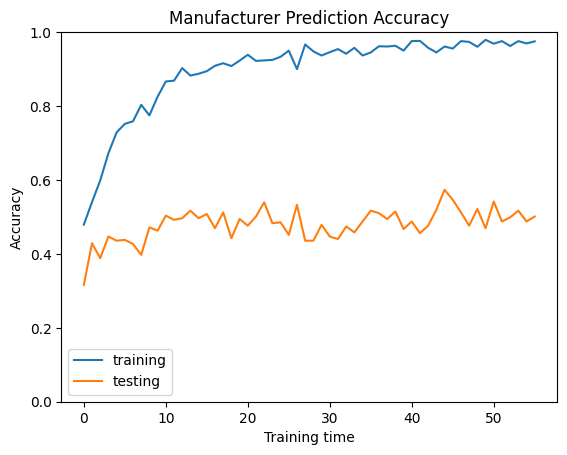

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['training','testing'])
plt.title('Manufacturer Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training time')
plt.ylim([0,1])

AttributeError: 'CustomDataset' object has no attribute 'classes'